# Stochastic Series Expansion (SSE) on spin-1/2 Heisenberg antiferromagnet

This is an simple code adopted from [Prof. Anders W. Sandvik](https://physics.bu.edu/~sandvik/) for simulating the Heisenberg model on square lattice. To understand the following content in jupyter, we assume students understand the basic in Monte Carlo simulation and basic quantum statistical mechanics. For the original source of the note, you can click [here](https://physics.bu.edu/~sandvik/programs/ssebasic/ssebasic.html)

### Background knowledge in Statistical mechanices

Denote $\psi$ as one of the possible configuration of the model. The average of certain function $f$ and partition funciton are as follows,

$$ \langle f \rangle = \frac{1}{Z} \sum f(\psi) W(\psi) $$
$$ Z = \sum_{\{ \psi \}} W(\psi) $$

where $W(\psi)$ is the weight of the configuration and $\{ \psi \}$ denote the set of all possible configurations of the model. 

As the model follows Maxwell-Boltzmann distribution, $W(\psi) = e^{- \beta E(\psi)}$, where $\beta = \frac{1}{T}$ is the inverse of temperature. 

Then, by consider the Taylor expansion of the $e^{- \beta E(\psi)}$ in the average expression,

$$e^{- \beta E(\psi)} = \sum_{n}^{\infty} \frac{(- \beta E(\psi) )^n}{n!}$$

we can rewrite the $\langle f \rangle$ and $Z$ as, 

$$ \langle f \rangle = \frac{1}{Z} \sum_{n}^{\infty} \sum_{\{ \psi \} } f(\psi)  \frac{(- \beta E(\psi) )^n}{n!} $$

$$ Z = \sum_{n}^{\infty} \sum_{\{ \psi \} } \frac{(- \beta E(\psi) )^n}{n!} $$ 

We are now sampling not only in the space $\{ \psi \}$, but in the space $\{ (\psi,n) \}$, which includes an extra dimension $n$ (the expansion order n) for us to visit in Monte Carlo simulation. 

With this modifcation, we need to guarantee that the terms $ \frac{(- \beta E(\psi) )^n }{n!} $ need to be positive (i.e. since **weight or probability cannot be a negative number**.) 

Therefore, we define a new weight to be used for sampling in this configuration space as, 

$$W(\psi, n) = \frac{\beta^n [\epsilon - E(\psi) ]^n}{n!}$$

we can choose a suitable constant $\epsilon$ so that $\epsilon - E(\psi) > 0$

Define $H(\psi) = \epsilon - E(\psi)$. With this defintion, the weight $W(\psi, n)$ can be rewritten as, 

$$W(\psi, n) = \frac{\beta^n [H(\psi)]^n}{n!}$$

The expectation of $\langle H(\psi) \rangle$ and partition function $Z$ can then be written as,

$$\langle H \rangle = \frac{1}{Z} \sum_{n}^{\infty} \sum_{ \{ \psi \} } H(\psi) W(\psi,n)  $$

$$Z = \sum_{n}^{\infty} \sum_{\{ \psi \} } W(\psi,n) $$


Below are then a bit tricky **since $H$ can be written as 1 of the term of $W(\psi,1)$ and $\beta$**.
 
Consider only the terms in the nominator of $\langle H \rangle$ expression,

$$\sum_{n}^{\infty} \sum_{ \{ \psi \} } H(\psi) W(\psi,n)$$

\begin{align}
    \sum_{n}^{\infty} \sum_{ \{ \psi \} } H(\psi) W(\psi,n) &= \sum_{n}^{\infty} \sum_{ \{ \psi \} } W(\psi,1) W(\psi,n) \\
    &= \sum_{n}^{\infty} \sum_{ \{ \psi \} } \frac{\beta [H(\psi)]}{1} \frac{\beta^n [H(\psi)]^n}{n!} \\
    &= \sum_{n}^{\infty} \sum_{ \{ \psi \} } \frac{n+1}{\beta} \frac{\beta^{n+1} [H(\psi)]^{n+1}}{(n+1)!} \\
    &= \sum_{n}^{\infty} \sum_{ \{ \psi \} } \frac{n+1}{\beta} W(\psi, n+1) \\
    &= \frac{1}{\beta} \sum_{m-1}^{\infty} \sum_{ \{ \psi \} } m W(\psi, m)  
    \end{align} 

With the result above, the $\langle H \rangle$ can be written as,

$$\langle H \rangle = \frac{1}{\beta} \left( \frac{1}{Z}  \sum_{n-1}^{\infty} \sum_{ \{ \psi \} } n W(\psi, n) \right) = \frac{1}{\beta} \langle n \rangle_W$$

(Why can we arrive the last result? By comparing the 2nd last expression and the standard average formula of $\langle f \rangle$, you will know it.)

And, 

\begin{align}
    \langle H \rangle &= \frac{1}{\beta} \langle m \rangle_{W} \\
    \epsilon - E &= \frac{1}{\beta} \langle m \rangle_{W} \\
    E &= \epsilon - \langle m \rangle_{W}
    \end{align} 

This result is impressive since it means that, **if we want to know the energy of the model, we just need to keep track of the expansion order when we do the Monte Carlo simulation**. 


### General idea of quantum mechanical SSE 

In quantum statistical mechanics, the average of function and partition function that follows Boltzmann distribution are as follows,

$$ \langle f \rangle = \frac{1}{Z} Tr\{ f e^{-\beta H}\}$$
$$ Z = Tr\{ e^{-\beta H} \}


With the idea that we have mentioned in last session, we consider the **Taylor expansion  $ e^ {-\beta H} $ = $ \sum _ {i=0}^ {\infty }  \frac {\beta^ {i}}{i!} $ $ (-H)^ {i} $**, the partition function is then written as:

$$
Z_ {SSE} = \sum _ {i=0}^{\infty}  \sum _ {\{ \psi \}_i} \frac{\beta^{i}}{i!} 
\langle \psi_i| (-H)^i | \psi_i \rangle 
$$



where $\{\psi\}_i$ denotes a complete set of states (i.e. a complete set of orthnormal basis).

Let us define the following notation,

\begin{equation}
    -H = \sum_{a,b} H_{a,b}
\end{equation}

and the meanings of indices are as follows,
- **a** - classifies the operator type 
    - Identity **I**, a=0 and b=0 
    - Diagonal operator, a=1 
    - Off-diagonal operator, a=2
    ( The reason of setting the a as 1&2 will be clearer in the section *"Implementation of SSE algorithm for spin-1/2 Heisenberg model in code"*)
- **b** - refers to the **bond label** that connecting the sites (*it will become clearer when you visit the defintion of bond_site structure in the coming section*)






When we consider the multiple of $H$ with the above defintion, we can see that 

\begin{align}
    (-H)^n &= \left( \sum_{a,b} H_{a,b} \right)^n \\
           &= \sum_{\{ H_{a,b} \} } \ \Pi^{n} H_{a,b}
\end{align}


(To arrive the last steps, you can consider a $H$ as a summation of other operator e.g. $H = A + B$. Then, when you multiply H by $n$ times i.e. $H^n = (A+B)^n = A^n + A^{n-1}B + \cdots$, you will notice that each terms in the expansion should have $n$ elements and therefore, there is $\Pi^{n}$ above. The $\sum_{\{ H_{a,b} \} } $ is just to sum up all possbile arrangement of A and B. The idea is still the same when $H$ is consist of more than 2 operators.)

Up to now, we can already put our result of $(-H)^n$ above back to the partition function. However, let us consider **giving an upper bound M instead of $\infty$** to the exponential Taylor series expansion.(i.e. the expansion becomes $ e^ {-\beta H} \approx \sum _ {i=0}^ {M}  \frac {\beta^ {i}}{i!} $ $ (-H)^ {i} $  ) since the terms with large $n$ would be expnontienally small and we will have **a very low chance to sample it under the importance sampling scheme**. 

**In the programme implementation, $M$ will be dynamically adjusted.** We will first set $M$ as a sufficiently large number. If that is too small, then the function *adjustcutoff()* would increase it by 1/3. On the other hand, if $M$ is larger than $n$ (i.e. $M>n$ ), the identity operator **I** (H_{0,0}) will be used to augmented the string. 

You can check the function *adjustcutoff()* for detailed implementation. 

After all, the parition function can be writtern as,

$$Z_{SSE} = \sum_{\psi} \sum_{\{ H_{a,b} \} }  \frac{\beta^i (M-i)!}{M!} \langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle$$


However, you might notice that $\langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle > 0$ needs to fulfill (i.e. it is part of the weight/probabilities and it cannot be zero). The presences of negative terms is called the **sign problem**. 

Luckily, in the our case, **positive definiteness is fulfilled (i.e. $\langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle > 0$ for all $| \psi \rangle$ state)**


### SSE algorithm for spin-1/2 Heisenberg model 

The Hamiltonian of Heisenberg model is, 

$$ H =  J \sum_{\langle i,j \rangle} \vec{S_i} \cdot \vec{S_j} =  J \sum_{\langle i,j \rangle} \left( S_i^{z} S_j^{z} + S_i^{x} S_j^{x} + S_i^{y} S_j^{y} \right)$$

where 
- $J$ is bond strength. It will be usually set to 1
- $\langle i,j \rangle$ denotes all the nearest neighbour $i, j$
- $\vec{S_i}$ denotes the spin at site $i$

With the defintion of operator $S_{j}^{\pm} = S_j^{x} \pm S_j^{y}$, we can rewrite the above operator in the following form, 

$$ H =  J \sum_{\langle i,j \rangle} \left[ S_i^{z} S_j^{z} + \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right) \right]$$


and we choose the **basis spins "up" and "down" along the z-direction**, where 

$$| \psi \rangle = | \uparrow_1 \uparrow_2 \cdots \uparrow_{N_s}  \rangle$$ 



We now **introduce a constant $JN_{b}C$** to the Hamlitonian and the purpose will later be clear. $N_{b}$ is the number of bond in the configuration. 

\begin{align}
    H &= J \sum_{\langle i,j \rangle} \left[ S_i^{z} S_j^{z} + \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right) \right] \\ 
    H - JN_{b}C &= J \sum_{\langle i,j \rangle } \left[ S_i^{z} S_j^{z} + \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right) \right]  - JN_bC \\ 
    H - JN_{b}C &= J \sum_{\langle i,j \rangle } \left[ (S_i^{z} S_j^{z} - C)+ \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right) \right]  \\ 
    - \left( H - JN_{b}C \right) &= J \sum_{\langle i,j \rangle } \left[ ( C - S_i^{z} S_j^{z}) - \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right) \right]  \\  
    - H_{new} &= J \sum_{\langle i,j \rangle } \left[ ( C - S_i^{z} S_j^{z}) - \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right) \right]  (\text{      Let     } H_{new} =  H - JN_{b}C)\\  
\end{align} 

According to the expression $-H = \sum_{a,b} H_{a,b}$ in the section introduced before, we can define the diagonal operator ($a=1$) and off-diagonal operator ($a=2$), 

$$H_{1,b} = C - S_i^{z} S_j^{z} $$ 
$$H_{2,b} = \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right)$$ 

We have **neglected the negative sign of the off-diagonal operators due to sublattice rotation**. 

From the definition of $H_{new}$, we can obtain the **energy expression**. With the relation $\langle H \rangle = - \frac{\partial }{\partial \beta} (\ln Z)$, 

\begin{align}
    \langle H_{new} \rangle &= - \frac{\partial }{\partial \beta} (\ln Z_{SSE}) \\ 
                      &= - \frac{1}{Z_{SSE}} \frac{\partial }{\partial \beta} Z_{SSE} \\
                      &= - \frac{1}{Z_{SSE}} \frac{\partial }{\partial \beta} \left( \sum_{\psi} \sum_{\{ H_{a,b} \} }  \frac{\beta^i (M-i)!}{M!} \langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle \right) \\ 
                      &= - \frac{1}{Z_{SSE}} \left( \sum_{\psi} \sum_{\{ H_{a,b} \} } (i) \frac{\beta^{i-1} (M-i)!}{M!} \langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle \right) \\ 
                      &= -  \frac{1}{\beta} \left( \frac{1}{Z_{SSE}}  \sum_{\psi} \sum_{\{ H_{a,b} \} } \frac{\beta^{i} (M-i)!}{M!} (i) |\langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle  \right)  (\text{   pull out     } \beta^{-1})  \\
                      &= -  \frac{1}{\beta} \langle i \rangle_{n} \\
\end{align}

where the result is similiar to the classical case. 

Then, since we have added the constant to the original $H$, we have to substract it from the expression. The normalized energy can then by obtained by,

\begin{align}
    \langle H_{new} \rangle &= - \frac{1}{\beta} \langle i \rangle_{n} \\
     \langle H \rangle - JN_{b}C &= - \frac{1}{\beta} \langle i \rangle_{n} \\ 
     \langle H \rangle &= - \frac{1}{\beta} \langle i \rangle_{n} + JN_{b}C \\ 
     E_{normalized} &= - \frac{1}{\beta N_s} \langle i \rangle_{n} + \frac{JN_{b}C}{N_s} \\     
\end{align}

where $N_s$ represents the number of sites in the configurations. 

### Implementation of SSE algorithm for spin-1/2 Heisenberg model in code

Below are few core elements to implement SSE algorithm in Python, 

- bond_site (*bsites* in the code)
    - it is a **labeling scheme of the sites and the bond** in the configuraiton.
    - For the 1D Heisenberg chain, taking L=4 as example, it has the following bond_sites scheme,

    **(add 1D Heisenberg chain bond_site graph)**
        
    - For the 2D square Heisenberg lattice, taking N=4x4 as example, it has the following bond_sites scheme,

    **(add 2D square Heisenberg lattice bond_site graph)**

    - Explanation of the construction is as follows. The bond_site basically takes 2 integer (i.e. `bsites[direction (either 1 or 2), bond_label]`). For example, bond with `bond_label=10` is connecting sites 10 and 11 in 2D square Heisenberg latticem, the `bsites[1,10]` would return 10 and `bsites[2,10]` would return 11. Another exampple would be `bond_label=32`, which connected site 16 and 4 (periodic boundary condition). `bsites[1,32]`, would return 16 and `bsites[2,32]` would return 4.

- *opstring* 
    - From the $Z_{SSE}$, there is a multiplication series of operator. (i.e. $\Pi_{n=1}^{M} H_{a,b}$, you can refer to the section *General idea of Quantum SSE*). We can use a **list in Python to store this multiplication series**. 
    - For each operator (i.e. each $H_{a,b}$ in  $\Pi_{n=1}^{M} H_{a,b}$), there are **2 pieces of information to encode**, 
        1. **type of operator (a)**: diagonal (a=1) or off-diagonal (a=2)
        2. **the bond the operator acting on (b)**:　b=bond_label
    - 　In the paper, it uses a clever way to encode the information, it defines $p = 2b + a-1$. 
        - if we want to know the **type operator**, we can calculate $p%2$ (you can put a=1 and a=2 back to the expression of p and think whether it is even or odd)
        - if we want to know the **the bond the operator acting on**, we can calculate $p//2$

- *spin* ($| \psi \rangle$)
    - Since we are using the basis spins "up" and "down" along the z-direction, it is pretty intuitive to represent it in a list of 1 (spin up) or -1 (spin down). 
    - e.g. for 4 sites 1D chain, $|\uparrow \uparrow \downarrow\uparrow \rangle$, it will be list [1,1,-1,1] in Python. 
    - **The idea of propagation states** 
        - From the $Z_{SSE}$, there is a term $\langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle = \langle \psi | H_{a_M,b_M} \cdots H_{a_2,b_2} H_{a_1,b_1} | \psi \rangle$. When the operator $H$ operates on the $| \psi \rangle$, it will either become a **new state (for off-diagoanl operator)** or it will become the **same state (for diagoanl operator)**. Therefore, the evolution $$\langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle$$ will be initutive to be represneted as the following "propagation graph". 

    - Viewing from top to bottom, the red solid circle represents the "spin-up" and blue void circle represents "spin-down". For a 1D `L=6` Hesienberg spin chain with `M=10`, the propagation graph could be the following, 

    **(Attached the propagation graph)**

- *vertexlist* 
    - It is constructed for the loop update (see the implementation in function `loop_update` below)
    - Each operators has 4 legs to involve in the loop, 

    **(Attached the operator graph)**

    - According to the propagation graph above, the vertex list would take the following form 

    **(Add the table of the corresponding vertexlist)**

    **(Explaination)** 

    


### Detailed balance condition, diagonal update and loop update

Similar to other Monte Carlo simulation, we start from a arbitary allowed configurations (i.e. weight is not 0 ) configuration and generate a Markov chain of configuraations by updating the previous configuration with respect to the detail balance condition and thus the desired probability distribution $P=W/Z$ is sampled. 

With Metroplis methods, the probabilities of accepting the changes to the previous configuration is, 

$$P_{accept}(A \rightarrow B) = min\left( \frac{W(B) P_{select}(B \rightarrow A)}{W(A) P_{select}(A \rightarrow B)}, 1 \right)$$

The above $P_{accept}$ has the 2 following implications, 
1. If the new configuration has a **larger weight** (or equal weight) (i.e. $W(B) P_{select}(B \rightarrow A) \ge W(A) P_{select}(A \rightarrow B)$), we will always accept the update
2. If the new configuration has a **smaller weight**, we will **still accept it** with probability that is equal to their **weight ratio**.

We will be using **diagonal update** and **loop update** for the update and both of them would satisfy the condition $P_{accept}(A \rightarrow B)$. But before discussing the details of the updating methods, let's looks into the details of operator operating on the state. 


Details of operator operating on the states 

Recall $Z_{SSE}$ ,$H_{diagonal}$,$H_{off-diagonal}$ for easier referencing, 

$$Z_{SSE} = \sum_{\psi} \sum_{\{ H_{a,b} \} }  \frac{\beta^i (M-i)!}{M!} \langle \psi | \Pi_{n=1}^{M} H_{a,b} | \psi \rangle$$

$$H_{\text{diagonal}} = H_{1,b} = C - S_i^{z} S_j^{z}$$

$$H_{\text{off-diagonal}} = H_{2,b} = \frac{1}{2} \left( S_i^{+} S_j^{-} +   S_i^{-} S_j^{+} \right)$$






## Code

In [16]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
def init_config(nn):
    global spin
    spin = [0]*nn

    for i in range(nn):
        spin[i] = 2*int(2*np.random.random())-1

    global mm
    mm = 20

    global opstring,nh
    opstring = [0]*mm
    nh = 0


In [ ]:
def makelattice():
    global nn,nb,lx,ly,bsites
    nn = lx * ly

    if ly!=1:
        nb = 2*nn
        bsites = np.array([[0]*nb,[0]*nb])

        for y1 in range(0,ly):
            for x1 in range(0,lx):
                s = 1+x1+y1*lx
                x2 = np.mod(x1+1,lx)
                y2 = y1
                bsites[0][s-1] = s
                bsites[1][s-1] = 1+x2+y2*lx
                x2 = x1
                y2 = np.mod(y1+1,ly)
                bsites[0][s+nn-1] = s
                bsites[1][s+nn-1] = 1+x2+y2*lx
    else:
        nn = lx
        nb = nn
        bsites = np.array([[0]*nb,[0]*nb])

        for x1 in range(lx):
            bsites[0][x1] = x1+1
            bsites[1][x1] = 1+x1+1

        bsites[1][lx-1] = 1


In [ ]:
def adjustcutoff():
    global mm,opstring
    mmnew = nh+nh//3
    if mmnew <= mm:
        return
    diff = mmnew-mm
    mm = mmnew
    opstring.extend([0]*(diff))

In [ ]:
def diagonalupdate():

    global spin,mm,nb,nh,aprob,dprob

    for i in range(mm):
        op = opstring[i]
        if op == 0:
            b = min(int(np.random.random()*nb)+1,nb)
            if spin[int(bsites[0][b-1])-1] != spin[int(bsites[1][b-1])-1]:
                if (aprob >= mm-nh) or (aprob >= np.random.random()*(mm-nh)):
                    opstring[i] = 2*b
                    nh += 1
        elif np.mod(op,2) == 0:
            p = dprob*(mm-nh+1)
            if (p >= 1 ) or (p>=np.random.random()):
                opstring[i] = 0
                nh -= 1
        else:
            b = op//2
            spin[int(bsites[0][b-1])-1] = -spin[int(bsites[0][b-1])-1]
            spin[int(bsites[1][b-1])-1] = -spin[int(bsites[1][b-1])-1]



In [ ]:
def loopupdate():
    global vertexlist,frstspinop,lastspinop,opstring,bsites,spin,mm,nn

    frstspinop = [0]*nn
    lastspinop = [0]*nn
    vertexlist = [0]*(4*mm)

    for i in range(nn):
        frstspinop[i] = -1
        lastspinop[i] = -1

    for v0 in np.arange(0,4*mm,4):
        op = opstring[v0//4]
        if op != 0:
            b = op//2
            s1 = bsites[0][b-1]
            s2 = bsites[1][b-1]
            v1 = lastspinop[s1-1]
            v2 = lastspinop[s2-1]
            if v1 != -1:
                vertexlist[v1] = v0
                vertexlist[v0] = v1
            else:
                frstspinop[s1-1] = v0

            if v2!=-1:
                vertexlist[v2] = v0+1
                vertexlist[v0+1] = v2
            else:
                frstspinop[s2-1] = v0+1

            lastspinop[s1-1] = v0+2
            lastspinop[s2-1] = v0+3
        else:
            for i in np.arange(v0,v0+4):
                vertexlist[i] = 0

    for sn in np.arange(0,nn): #sn is the spin number from 0 to nn-1
        v1 = frstspinop[sn]
        if v1!=-1:
            v2 = lastspinop[sn]
            vertexlist[v2] = v1
            vertexlist[v1] = v2

    for v0 in np.arange(0,4*mm,2):
        if vertexlist[v0]<1:
            continue
        v1 = v0
        if np.random.random()<0.5:
            while True:
                opstring[v1//4] = opstring[v1//4]^1
                vertexlist[v1] = -1
                v2 = v1^1
                v1 = vertexlist[v2]
                vertexlist[v2] = -1
                if v1==v0:
                    break
        else:
            while True:
                vertexlist[v1]=0
                v2 = v1^1
                v1 = vertexlist[v2]
                vertexlist[v2] = 0
                if v1==v0:
                    break
    for i in range(nn):
        if frstspinop[i]!=-1:
            if vertexlist[int(frstspinop[i])]==-1:
                spin[i] = -spin[i]
        else:
            if np.random.random()<0.5:
                spin[i] = -spin[i]

In [ ]:
def measureobservables():
    global enrg1,enrg2,amag1,amag2,am1,am2,ax1,opstring,bsites,spin,mm,nn
    am =0
    for i in range(nn):
        am = am+spin[i]*(-1)**(np.mod(i,lx)+i//lx)
    am = am/2
    am1 = 0.0
    am2 = 0.0
    ax1 = 0.0

    for i in range(mm):
        op = opstring[i]
        if op ==0:
            continue
        elif np.mod(op,2) ==1:
            b = op//2
            s1 = bsites[0][b-1]
            s2 = bsites[1][b-1]
            spin[s1-1] = -spin[s1-1]
            spin[s2-1] = -spin[s2-1]
            am = am+2*spin[s1-1]*(-1)**(np.mod(s1-1,lx)+(s1-1)//lx)
        ax1 = ax1+float(am)
        am1 = am1+float(abs(am))
        am2 = am2+float(am)**2

    if nh!=0:
        ax1 = (ax1**2+am2)/(float(nh)*float(nh+1))
        am1 = am1/nh
        am2 = am2/nh
    else:
        am1 = float(abs(am))
        am2 = float(am)**2
        ax1 = am2



In [ ]:
#main
start = time.time()

lx,ly = 8,1
beta=16
nbin=10

E_lst = []
E_err = []

makelattice()
init_config(nn)

aprob = 0.5*beta*nb
dprob = 1.0/(0.5*beta*nb)

nh_lst = []
nh_mc = []
dis = []

eqstep = 2000
mcstep = 20000
nbin = 10
bin_step = mcstep//nbin

for i in range(eqstep):
    diagonalupdate()
    loopupdate()
    adjustcutoff()


for i in range(mcstep):
    diagonalupdate()
    loopupdate()
    nh_mc.append(nh)
    dis.append(nh)
    if (i+1)%(bin_step) == 0:
        print("bin:",(i+1)//bin_step)
        nh_lst.append(np.mean(nh_mc))
        nh_mc = []


E = -(np.mean(nh_lst)/(beta*nn)-nb/(4*nn))
err = np.std(nh_lst)/(beta*nn)/np.sqrt(nbin)
E_lst.append(E)
E_err.append(err)

end = time.time()
print("Running time:", end-start)
print("E:",E_lst[0])
print("err:",E_err[0])



bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
bin: 8
bin: 9
bin: 10
Running time: 29.01471185684204
E: -0.45647265625
err: 0.0008489840550806885


Deal with the following later 

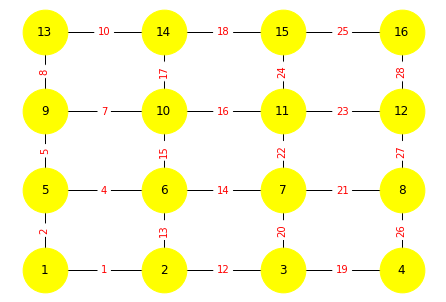

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a 4x4 grid graph
G = nx.grid_2d_graph(4, 4, periodic=False)  # Initially not periodic

# Relabel nodes to a more straightforward numbering
mapping = {(x, y): 4 * y + x + 1 for y in range(4) for x in range(4)}
G = nx.relabel_nodes(G, mapping)

# Add edges on the RHS to connect rightmost nodes back to leftmost nodes in the same row
for y in range(4):
    G.add_edge(4 * y + 4, 4 * y + 1)  # Connect node 4 to node 1 in each row, node 8 to 5, etc.

# Define positions for each node
pos = {node: ((node - 1) % 4, (node - 1) // 4) for node in G.nodes()}

# Draw the nodes and edges
nx.draw(G, pos, with_labels=True, node_color='yellow', edge_color='black', node_size=2000)

# Add edge labels
edge_labels = {edge: f'{idx+1}' for idx, edge in enumerate(G.edges())}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()

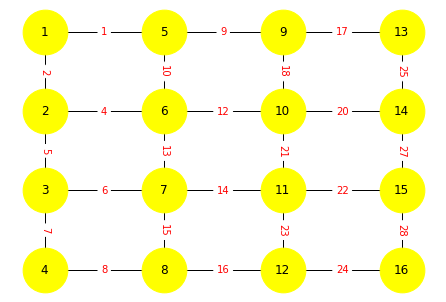